# Electron Cooling

In [2]:
%load_ext autoreload

## Notebook Initialization

In [109]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
import pickle
import copy

import darkhistory.physics as phys
import darkhistory.spec.transferfunction as tf
import darkhistory.utilities as utils

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec

## Import ICS Tables

In [95]:
raw_nonrel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_nonrel.raw","rb"))
raw_rel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_rel.raw","rb"))
raw_engloss_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_englossspec.raw","rb"))

Prepare the ICS transfer functions from these files.

In [96]:
eleceng = phys.me + 10**np.arange(-4, 12, 0.4)
photeng = 10**np.arange(-4, 12, 0.4)
T = 10

ICS_tf = ics_spec(eleceng, photeng, T, 
                  nonrel_tf = raw_nonrel_ICS_tf, rel_tf = raw_rel_ICS_tf
                 )

engloss_tf = engloss_spec(eleceng, photeng, T, 
                          nonrel_tf = raw_engloss_tf, 
                          rel_tf = raw_rel_ICS_tf
                         )

Check that everything is working as expected...

[0.0001, 10000000000000.0, 1e-16, 1000.0]

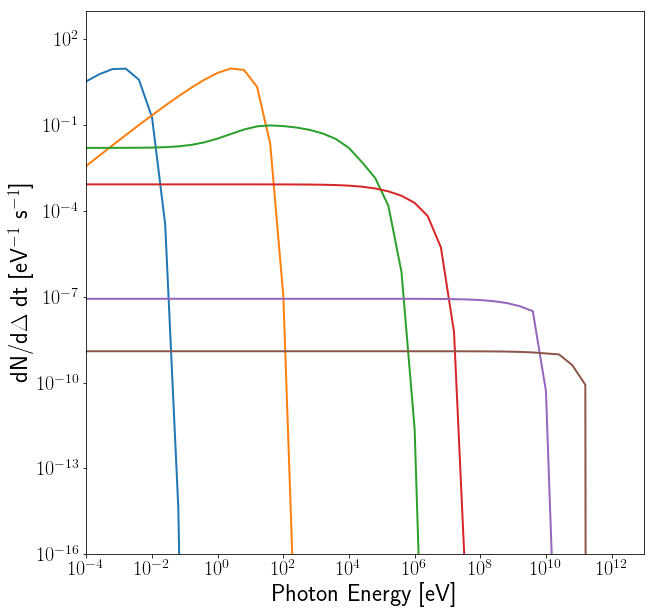

In [97]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
comp_elec_kineng = np.array([1e-3, 1e4, 1e7, 1e8, 1e10, 1e11])

engloss_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/d$\Delta$ dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e13, 1e-16, 1e3])

In [110]:
sec_elec_tf = copy.deepcopy(engloss_tf)
i = 0
new_eng = sec_elec_tf.in_eng[i] - sec_elec_tf[i].eng
sec_elec_tf[i].shift_eng(new_eng, reverse=True)

[[  4.74974513e-12   6.27396218e-04]]
1


IndexError: index 1 is out of bounds for axis 0 with size 1

In [79]:
utils.compare_arr([sec_elec_tf[3].eng, sec_elec_tf[3].dNdE, 
                   engloss_tf[3].eng,  engloss_tf[3].dNdE])

[[ 0.0  nan  0.0001  2.8594334]
 [ 2.3961785e+11  0.0  0.00025118864  5.2551185]
 [ 3.3501144e+11  0.0  0.00063095734  8.4249211]
 [ 3.7298831e+11  0.0  0.0015848932  10.038772]
 [ 3.8810717e+11  0.0  0.0039810717  5.5605645]
 [ 3.941261e+11  0.0  0.01  0.35329402]
 [ 3.9652228e+11  0.0  0.025118864  6.843194e-05]
 [ 3.9747621e+11  0.0  0.063095734  8.4737928e-15]
 [ 3.9785598e+11  0.0  0.15848932  5.175852e-40]
 [ 3.9800717e+11  0.0  0.39810717  0.0]
 [ 3.9806736e+11  0.0  1.0  0.0]
 [ 3.9809132e+11  0.0  2.5118864  0.0]
 [ 3.9810086e+11  0.0  6.3095734  0.0]
 [ 3.9810466e+11  0.0  15.848932  0.0]
 [ 3.9810617e+11  0.0  39.810717  0.0]
 [ 3.9810677e+11  0.0  100.0  0.0]
 [ 3.9810701e+11  0.0  251.18864  0.0]
 [ 3.9810711e+11  0.0  630.95734  0.0]
 [ 3.9810715e+11  0.0  1584.8932  0.0]
 [ 3.9810716e+11  0.0  3981.0717  0.0]
 [ 3.9810717e+11  0.0  10000.0  0.0]
 [ 3.9810717e+11  0.0  25118.864  0.0]
 [ 3.9810717e+11  0.0  63095.734  0.0]
 [ 3.9810717e+11  0.0  158489.32  0.0]
 [ 3.98107

0

In [93]:
a = np.array([1,2,3,4,5])
a[a < 2]

array([1])